<a href="https://colab.research.google.com/github/bikash119/bikash119/blob/main/learn_pytorch_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Goal : 
`python train.py --model MODEL_NAME --batch_size BATCH_SIZE --lr LEARNING_RATE --num_epochs NUM_EPOCHS`

Example `python train.py --model tinyvgg --batch_size 32 --lr 0.001 --num_epochs 10`

<pre>
deep_learning_classification_prj
  ├── src
  │   ├── data_setup.py
  │   ├── train.py
  │   ├── engine.py
  │   ├── utils.py
  │   ├── model.py
  ├── model
  │   ├── model_from_script.pth
  │   ├── model_from_cells.pth
  ├── data
  │   ├── root_data_folder
  │       ├── train
  │           ├── class_a
  │               ├── img_1.jpg|png
  │               ├── ....
  │               ├── img_n.jpg|png
  │           ├── class_b
  │           ├── class_c
  └───────├── test
              ├── class_a
              ├── class_b
              ├── class_c
  
</pre>


## Cell to download images from a github repo

In [1]:
import os
import pathlib
from pathlib import Path
import requests
import zipfile

## Setup data folder
root_path = Path("deep_learning_classification/data/")
img_path = root_path / "pizza_steak_sushi"

if img_path.is_dir():
  print(f'{img_path} directory exists.')
else:
  print(f'Creating directory {img_path}')
  img_path.mkdir(parents=True, exist_ok=True)

## Download zip file 
with open(root_path/'pizz_steak_sushi.zip', 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f'Downloading zip file...')
  f.write(request.content)

## unzip the zip file
with zipfile.ZipFile(root_path/'pizz_steak_sushi.zip', 'r' ) as zip_ref:
  print(f'Unzipping data...')
  zip_ref.extractall(img_path)

## Remove zip file
os.remove(root_path/'pizz_steak_sushi.zip')

deep_learning_classification/data/pizza_steak_sushi directory exists.
Unzipping data...


In [2]:
### Create a src directory
root_path = Path('deep_learning_classification')
src = root_path/'src'
if src.is_dir():
  print(f'{src} directory exists')
else:
  src.mkdir(parents=True, exist_ok=True)
  print(f'Created {src} directory')

deep_learning_classification/src directory exists


## Create pytorch Datasets and DataLoaders

In [3]:
%%writefile deep_learning_classification/src/data_setup.py
"""
Contains functionality to create pytorch DataLoaders from image classification usecases
"""

import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from typing import Tuple, Dict, List

NUM_WORKERS = os.cpu_count()
def create_dataloader(train_dir:str,
                      test_dir: str,
                      train_transforms: transforms.Compose,
                      test_transforms: transforms.Compose,
                      batch_size: int,
                      num_workers: int=NUM_WORKERS) -> Tuple[DataLoader, DataLoader, List[str]]:
  """
   Creates train and test dataloaders

    Takes in training directory and testing directory and creates Pytorch Datasets which are then 
    used to create Pytorch DataLoaders

    Args:
      train_dr(str) : Folder containing images to be used for training the model
      test_dir(str) : Folder containing images to be used for testing the model
      train_transforms ( transforms.Compose) : Transformation to be applied on the images used for training
      test_transform ( transforms.Compose) : Transformation to be applied on the images used for testing
      batch_size(int) : Size of mini batch or Number of samples per batch in each DataLoaders
      num_workers (int) : Number of workers per DataLoader ( mostly equals to the number of CPU)

    Returns:
      A Tuple containing 
        train_dataloader ( torch.utils.data.DataLoader): A pytorch DataLoader for training dataset
        test_dataloader ( torch.utils.data.DataLoader) : A pytorch DataLoader for testing dataset
        classes ( List[str]) : A list of string representing the image classes.
    
    Example usage:
      train_dataloader, test_dataloader, classes = create_dataloaders(train_dir = path/to/train_img/folder,
                                                                      test_dir = path/to/train_img/folder,
                                                                      train_transforms= some_tranforms,
                                                                      test_transforms = some_transforms,
                                                                      batch_size= 32,
                                                                      num_workers = 2)
  """

  # Create pytorch datasets using images in train and test folder
  train_dataset = datasets.ImageFolder(root=train_dir,
                                       transform=train_transforms)
  test_dataset = datasets.ImageFolder(root=test_dir,
                                      transform=test_transforms)
  
  ## Get Image classes
  classes = train_dataset.classes

  # Create pytorch dataloaders from datasets
  train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=NUM_WORKERS)
  
  test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=NUM_WORKERS)
  
  return train_dataloader, test_dataloader, classes
  

Overwriting deep_learning_classification/src/data_setup.py


In [4]:
import sys
sys.path.append('/content/deep_learning_classification')
from src import data_setup
from torchvision import transforms
train_dir = img_path/'train'
test_dir = img_path/'test'
transforms=transforms.Compose([
    transforms.Resize((64,64))
])
NUM_WORKERS = os.cpu_count()
train_dataloader , test_dataloader, classes = data_setup.create_dataloader(train_dir= train_dir,
                                                                test_dir = test_dir,
                                                                train_transforms=transforms,
                                                                test_transforms=transforms,
                                                                batch_size=32,
                                                                num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7fc4c7493520>,
 ['pizza', 'steak', 'sushi'])

## Make the model

In [5]:
%%writefile deep_learning_classification/src/model.py
"""
  Contains the model architecture code
"""


import torch
from torch import nn

class TinyVGG(nn.Module):

  """
    Create the TinyVGG architecure

    Replicates the TinyVGG architecture from the CNN Explainer website in pytorch.
    See the original architecture here: https://poloclub.github.io

    Args:
      input_shape(int) : An integer indicating number of input channels.
      hidden_units(int) : An integer indicating number of hidden units between layers
      output_shape(int) : An integer indicating number of classes

    Example Usage
      model_v0 = TinyVGG(input_shape=3,
                         hidden_units=10,
                         output_units=3)
  """
  def __init__(self, 
               input_shape: int,
               hidden_units:int,
               output_shape: int) -> None:
    
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 13 * 13,
                  out_features=output_shape)
    )

  def forward(self,x)-> torch.Tensor:
    return self.classifier(self.block_2(self.block_1(x)))


Overwriting deep_learning_classification/src/model.py


In [6]:
from src import model
import torch

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_v2 = model.TinyVGG(input_shape=3, 
                   hidden_units=10, 
                   output_shape=len(classes)).to(device)

model_v2

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [7]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_v2,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Create the Training engine.

In [8]:
%%writefile deep_learning_classification/src/engine.py
"""
  Contains function for training and testing a pytorch model
"""

import torch
from torch import nn
from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device
               )-> Tuple[float, float]:
  """
    Trains a pytorch model for single Epoch

    Turns a target Pytorch model to training mode and then executes all the training steps
    forward pass,
    loss calculation,
    zero gradient,
    backpropagation
    update parameters
    Args:
      model(nn.Module): Model to be trained
      dataloader(torch.utils.data.DataLoader) : A DataLoader to be used for training the model
      loss_fn(nn.Module) : A function to calculate the loss
      optimizer(torch.optim.Optimzer) : A pytorch optimizer to help minimize the loss
      device(torch. device) : A target device to compute on 'cpu' or 'cuda'
    
    Returns:
      A tuple of training loss and training accuracy metrics in the form of
      (training_loss, training_acc)

    Example Usage : 
      train_loss, train_acc = train_step(model=model_v0, 
                                         dataloader=train_dataloader,
                                         loss_fn= nn.CrossEntropyLoss(),
                                         optimizer=torch.optim.Adam(params=model_v0.parameters(),lr=0.001),
                                         device='cuda'
      )
    
  """

  #Put the model to train mode
  model.train()

  #Setup the train loss and train accuracy
  train_loss, train_acc = 0,0

  # Iterate over the dataloader
  for batch,(X,y) in enumerate(dataloader):

    #send data to device
    X,y = X.to(device),y.to(device)

    #Forward pass
    pred_logits = model(X)

    # Calculate Loss
    loss = loss_fn(pred_logits, y)
    train_loss += loss.item()

    # Calculate Acc
    pred_label = torch.argmax(torch.softmax(pred_logits,dim=1),dim=1)
    train_acc += (pred_label == y).sum().item()/ len(pred_logits)

    # Zero gradient
    optimizer.zero_grad()

    # Back prop
    loss.backward()

    # update parameters
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device:torch.device)-> Tuple[float,float]:

    """
    Tests a pytorch model for single Epoch

    Turns a target Pytorch model to eval mode and then executes all the testing steps
    forward pass,
    loss calculation,
    
    Args:
      model(nn.Module): Model to be trained
      dataloader(torch.utils.data.DataLoader) : A DataLoader to be used for testing the model
      loss_fn(nn.Module) : A function to calculate the loss
      device(torch. device) : A target device to compute on 'cpu' or 'cuda'
    
    Returns:
      A tuple of testing loss and testing accuracy metrics in the form of
      (testing_loss, testing_acc)

    Example Usage : 
      test_loss, test_acc = test_step(model=model_v0, 
                                         dataloader=train_dataloader,
                                         loss_fn= nn.CrossEntropyLoss(),
                                         device='cuda'
      )
    
  """

    #Put the model in eval mode
    model.eval()

    # Intialize the test_loss and test_acc
    test_loss, test_acc = 0,0
    
    #Turn on the inference context manager
    with torch.inference_mode():
      
      # Loop over the dataloader
      for batch,(X,y) in enumerate(dataloader):
        
        # Send data to target device
        X,y = X.to(device),y.to(device)

        
        # Forward pass
        pred_logits = model(X)

        # Calculate Loss
        loss = loss_fn(pred_logits,y)
        test_loss += loss.item()
        
        # Calculate acc
        pred_labels = torch.argmax(torch.softmax(pred_logits,dim=1),dim=1)
        test_acc += (pred_labels == y).sum().item()/ len(pred_labels) 

      # Calculate the avg loss and accuracy across all batches.  
      test_loss /= len(dataloader)
      test_acc /= len(dataloader)
    return test_loss, test_acc


def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          epochs: int) -> Dict[str,List[float]]:
  
  """
    Trains and Tests the pytorch model

    Passes a pytorch model through the train_step and the test_step function for
    a epochs number of times.
    Args:
      model(nn.Module): Model to be trained
      train_dataloader(torch.utils.data.DataLoader) : A DataLoader to be used for training the model
      test_dataloader(torch.utils.data.DataLoader) : A DataLoader to be used for testing the model
      loss_fn(nn.Module) : A function to calculate the loss
      optimizer(torch.optim.Optimzer) : A pytorch optimizer to help minimize the loss
      device(torch.device) : A target device to compute on 'cpu' or 'cuda'
      epochs(int): Number of times the model should pass over the training and the testing dataset.
    
    Returns:
      A dictionary containing the train_loss, train_acc, test_loss & test_acc. 
      Each metrics have a value in list for each epoch

      The output form :
        {
          train_loss : List[float]
          train_acc : List[float]
          test_loss : List[float]
          test_acc : List[float]
        }
  
  """
  # Create a empty dictionary to hold the results

  results = {
      'train_loss':[]
      ,'train_acc':[]
      ,'test_loss':[]
      ,'test_acc':[]
  }

  

  for epoch in tqdm(range(epochs)):
    train_loss , train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f'Epoch : {epoch+1} |'
          f'train_loss : {train_loss:.4f} |'
          f'train_acc : {train_acc:.4f} |'
          f'test_loss : {test_loss:.4f} |'
          f'test_acc : {test_acc:.4f} |' 
    )
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
  
  return results





Overwriting deep_learning_classification/src/engine.py


In [9]:
%%writefile deep_learning_classification/src/utils.py
"""
  Contains various utility functions for pytorch model training and saving
"""

import torch
from torch import nn
from pathlib import Path

def save_model(model: nn.Module,
              target_dir: str,
              model_name: str):
  """
    Saves a pytorch model to a target directory
    Args:
      model (nn.Module): a pytorch model to be saved
      target_dir (str): A directory for saving the model
      model_name (str): The filename to given to the model. Should include either 
                        .pt or .pth as the file extension 

    Returns : None

    Example usage
      save_model(model=model_0,
                 target_dir="models",
                 model_name="deep_learning_classification.pth")
  """

  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,exist_ok=True)

  # Create model save path
  assert model_name.endswith('.pt') or model_name.endswith('pth'),"model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path/model_name

  # Save the model state_dict()
  print(f'[INFO] Saving model to : {model_save_path}')
  torch.save(obj=model.state_dict(),
             f=model_save_path)
  



Overwriting deep_learning_classification/src/utils.py


In [10]:
%%writefile deep_learning_classification/src/train.py
"""
  Trains a pytorch classification model using device agnostic code
"""

import os
import torch
from torch import nn
import torchvision
from torchvision import transforms
import data_setup, engine, model, utils

## Set up hyperparameters
NUM_EPOCHS= 5
BATCH_SIZE= 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

## Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device used : {device}')

## Setup transforms
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

## Setup the directories
train_dir = "/content/deep_learning_classification/data/pizza_steak_sushi/train"
test_dir = "/content/deep_learning_classification/data/pizza_steak_sushi/test"

train_dataloader, test_dataloader, classes = data_setup.create_dataloader(train_dir= train_dir,
                                                                test_dir = test_dir,
                                                                train_transforms=train_transforms,
                                                                test_transforms=test_transforms,
                                                                batch_size=32)
print(f'Target classes : {classes}')

## Setup model
torch.manual_seed(42)
model = model.TinyVGG(input_shape=3, 
                   hidden_units=HIDDEN_UNITS, 
                   output_shape=len(classes)).to(device)

## Setup the loss function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE)

## Train the model
results = engine.train(model= model,
            train_dataloader= train_dataloader,
            test_dataloader= test_dataloader,
            loss_fn= loss_fn,
            optimizer= optimizer,
            device= device,
            epochs= NUM_EPOCHS)

## Save the model
utils.save_model(model= model,
                 target_dir= '/content/deep_learning_classification/models' ,
                 model_name= 'script_mode_tinyvgg.pth')


Overwriting deep_learning_classification/src/train.py


In [11]:
!python /content/deep_learning_classification/src/train.py


Device used : cuda
Target classes : ['pizza', 'steak', 'sushi']
  0% 0/5 [00:00<?, ?it/s]Epoch : 1 |train_loss : 1.1069 |train_acc : 0.2969 |test_loss : 1.0994 |test_acc : 0.2396 |
 20% 1/5 [00:04<00:19,  4.89s/it]Epoch : 2 |train_loss : 1.1021 |train_acc : 0.3047 |test_loss : 1.0721 |test_acc : 0.5417 |
 40% 2/5 [00:07<00:11,  3.82s/it]Epoch : 3 |train_loss : 1.0917 |train_acc : 0.4297 |test_loss : 1.0839 |test_acc : 0.5634 |
 60% 3/5 [00:11<00:06,  3.49s/it]Epoch : 4 |train_loss : 1.0923 |train_acc : 0.3164 |test_loss : 1.0676 |test_acc : 0.5833 |
 80% 4/5 [00:14<00:03,  3.45s/it]Epoch : 5 |train_loss : 1.0865 |train_acc : 0.3672 |test_loss : 1.0759 |test_acc : 0.5436 |
100% 5/5 [00:17<00:00,  3.46s/it]
[INFO] Saving model to : /content/deep_learning_classification/models/script_mode_tinyvgg.pth


# Transfer Learning

In [12]:
from src import data_setup
import torchvision
from torchvision import transforms
train_dir = img_path/'train'
test_dir = img_path/'test'
#manual transforms
transforms=transforms.Compose([
    transforms.Resize((64,64))
])
NUM_WORKERS = os.cpu_count()
manual_transform_train_dataloader , manual_transform_test_dataloader, classes = data_setup.create_dataloader(train_dir= train_dir,
                                                                test_dir = test_dir,
                                                                train_transforms=transforms,
                                                                test_transforms=transforms,
                                                                batch_size=32,
                                                                num_workers=NUM_WORKERS)

manual_transform_train_dataloader, manual_transform_test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7fc4c73cf460>,
 ['pizza', 'steak', 'sushi'])

In [13]:
## Get pre-trained weights and tranforms

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [14]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
auto_transform_train_dataloader , auto_transform_test_dataloader, classes = data_setup.create_dataloader(train_dir= train_dir,
                                                                test_dir = test_dir,
                                                                train_transforms=auto_transforms,
                                                                test_transforms=auto_transforms,
                                                                batch_size=32,
                                                                num_workers=NUM_WORKERS)

auto_transform_train_dataloader, auto_transform_test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7fc4c73cc8e0>,
 ['pizza', 'steak', 'sushi'])

In [16]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
summary(model,input_size=[32,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=18,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] 864                True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64                 True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 True
│    │    └─M

## Freezing the base 

In [18]:
for param in model.features.parameters():
  param.requires_grad=False

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from torch import nn
# Get the lenght of target classes.
output_shape = len(classes)

## Recreate the classifier layer and seed it to target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280
              ,out_features=3
              ,bias=True)
).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [20]:
summary(model,input_size=[32,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train the model

In [21]:
## Define the loss function and optimizer
from src import engine
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

from timeit import default_timer as timer

start_time = timer()

results = engine.train(model=model,
          train_dataloader=auto_transform_train_dataloader,
          test_dataloader=auto_transform_test_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          device=device,
          epochs=5)
end_time = timer()
print(f'[INFO] Total Training time : {end_time - start_time:3f}s')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 1 |train_loss : 1.0467 |train_acc : 0.3867 |test_loss : 0.8372 |test_acc : 0.7339 |
Epoch : 2 |train_loss : 0.9123 |train_acc : 0.6328 |test_loss : 0.7120 |test_acc : 0.8864 |
Epoch : 3 |train_loss : 0.7654 |train_acc : 0.7422 |test_loss : 0.6891 |test_acc : 0.8864 |
Epoch : 4 |train_loss : 0.7187 |train_acc : 0.7383 |test_loss : 0.5999 |test_acc : 0.8655 |
Epoch : 5 |train_loss : 0.6184 |train_acc : 0.7773 |test_loss : 0.5966 |test_acc : 0.8456 |
[INFO] Total Training time : 16.903236s


In [22]:
results

{'train_loss': [1.0467268377542496,
  0.9122966006398201,
  0.7653968259692192,
  0.7186634540557861,
  0.618395496159792],
 'train_acc': [0.38671875, 0.6328125, 0.7421875, 0.73828125, 0.77734375],
 'test_loss': [0.8372472127278646,
  0.7120197415351868,
  0.6890648603439331,
  0.5998919010162354,
  0.5966044068336487],
 'test_acc': [0.7339015151515151,
  0.8863636363636364,
  0.8863636363636364,
  0.8655303030303031,
  0.8456439393939394]}

In [23]:
from src import utils
utils.save_model(model= model,
                 target_dir= '/content/deep_learning_classification/models' ,
                 model_name= 'pre_trained_efficient_bo.pth')

[INFO] Saving model to : /content/deep_learning_classification/models/pre_trained_efficient_bo.pth


In [24]:
%%writefile deep_learning_classification/src/plot_loss.py
"""
  Contains function to display the loss curve given the results from 
  model training
"""

from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
def plot_loss_curve(results:Dict[str,List[float]]):
  """
    This function plots the loss and accuracy curve.

    Args:
      results(Dict[String,List[float]]) : A dictionary of the form
      {
        "train_loss":[]
        ,"train_acc":[]
        "test_loss":[]
        "test_acc":[]
      }
    Returns: None
  """

  ## Loss values
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  ## Accuracy values
  train_acc = results['train_acc']
  test_acc = results['test_acc']

  epochs = range(len(train_loss))

  ## Setup the plot
  plt.figure(figsize=(15,7))

  ## plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss, label='train')
  plt.plot(epochs,test_loss, label='test')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  ## Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,train_acc, label='train')
  plt.plot(epochs,test_acc, label='test')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

Overwriting deep_learning_classification/src/plot_loss.py


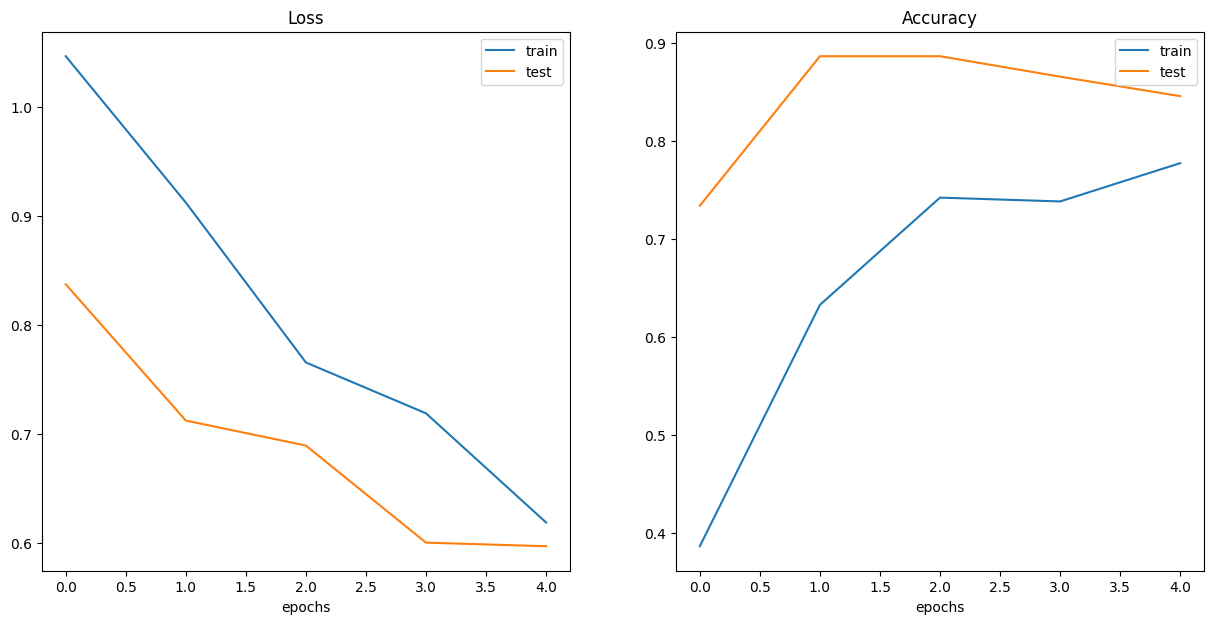

In [25]:
from src import plot_loss
plot_loss.plot_loss_curve(results)